In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/energy_time_60hr_most.root")
f.ls()

TFile**		./data/energy_time_60hr_most.root	
 TFile*		./data/energy_time_60hr_most.root	
  KEY: TCanvas	c1;1	c1


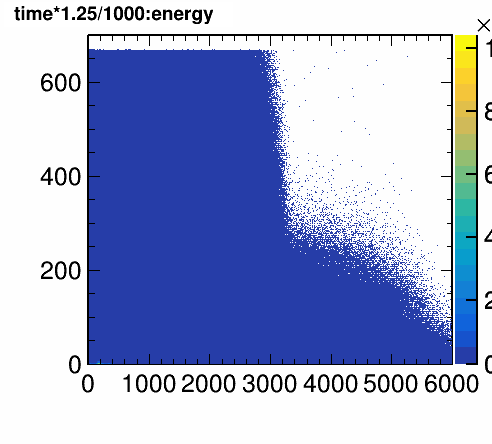

In [3]:
c1 = f.Get("c1")
c1.Draw()

In [4]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7ffffd6ca530>


In [5]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


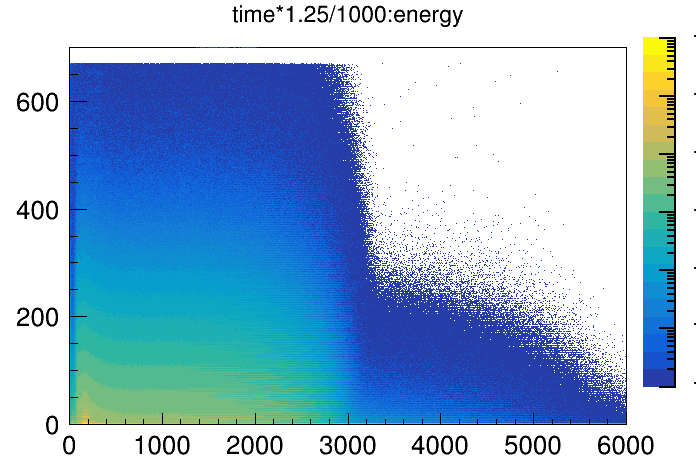

In [6]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

f = r.TFile("./data/gm2offline_ana.root")
f.cd("farline/calo1")
#f.ls()

c = r.TCanvas()
evt = f.Get("farline").Get("calo1").Get("energy_vs_time").Clone()
for calo in range(2,25):
    evt2 = f.Get("farline").Get("calo"+str(calo)).Get("energy_vs_time").Clone()
    evt.Add(evt2,1)
evt.Draw("colz")
c.SetLogz()
c.Draw()

evt.Reset()
evt.Add(h,1)

In [7]:
evt = h.Clone()

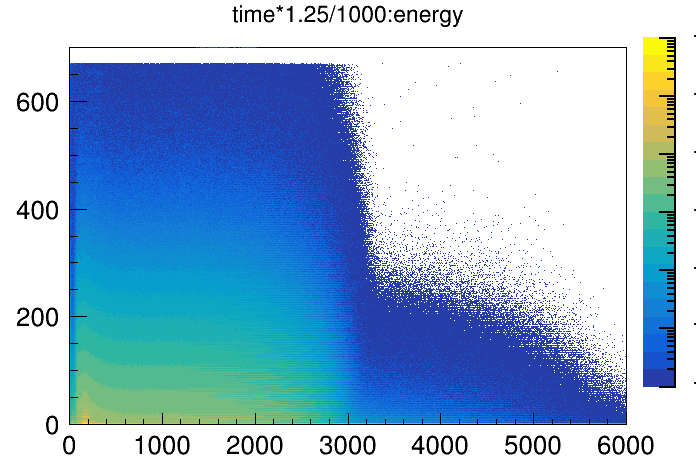

In [8]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

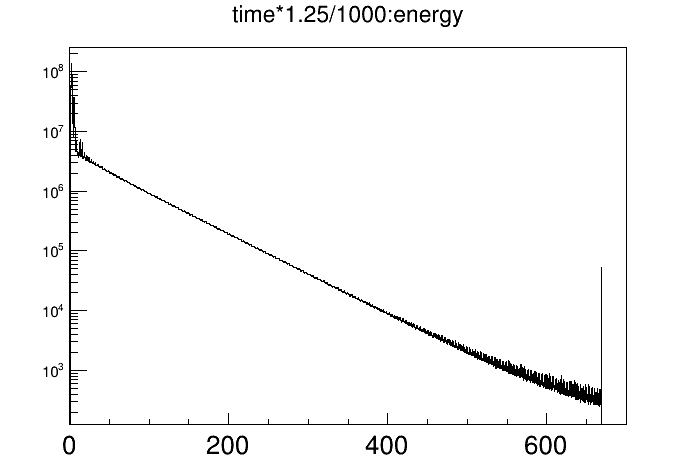

In [9]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

In [10]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > 30 and binCenter < 600):
        timeBinCenters.append(binCenter)

In [11]:
timeBinCenters[:10]

[30.010638297872337,
 30.159574468085104,
 30.30851063829787,
 30.457446808510635,
 30.606382978723403,
 30.755319148936167,
 30.904255319148934,
 31.0531914893617,
 31.202127659574465,
 31.351063829787233]

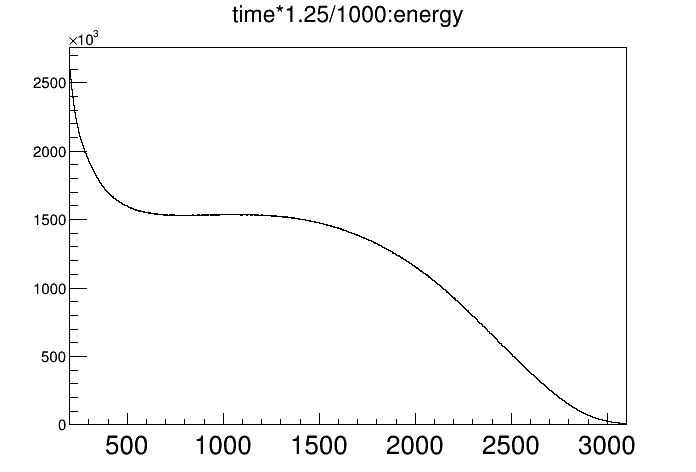

In [12]:
c2 = r.TCanvas()
e1 = 200 #200 and 3100 produced a stable result in the visualizer
e2 = 3100
t1 = 30
t2 = 600
evt.GetXaxis().SetRangeUser(e1,e2)
evt.GetYaxis().SetRangeUser(30,600)

cuti = r.TCutG("cuti")
cuti.SetPoint(0,e1,t1)
cuti.SetPoint(1,e2,t1)
cuti.SetPoint(2,e2,t2)
cuti.SetPoint(3,e1,t2)
cuti.SetPoint(4,e1,t1)

h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
#h.Scale(1/(h.GetEntries()))
h.Draw()
c2.Draw()

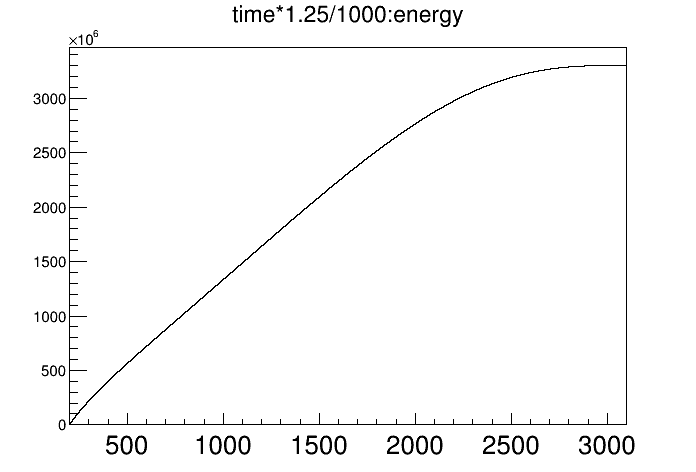

In [13]:
hcum = h.GetCumulative()
c2 = r.TCanvas()
hcum.Draw()
c2.Draw()

In [14]:
hscaled = h.Clone("hscaled")
hscaled.Scale(1/(hscaled.GetEntries()))

In [15]:
ndivs = len(timeBinCenters)
numberOfBins = 2
print(ndivs)
timeSlices = []
timeSlicesCum = []
times = []
for div in range(ndivs):
    t1 = timeBinCenters[div] - timeBinWidth*numberOfBins
    t2 = timeBinCenters[div] + timeBinWidth*numberOfBins
    evt.GetYaxis().SetRangeUser(t1,t2)
    
    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
    htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))
    #htemp.Scale(1/(htemp.GetEntries()))
    
    '''
    hprint = htemp.Clone("hprint")
    hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaled.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    c.Print("./images/evt_"+str(div).zfill(5)+".png")
    '''
    
    timeSlices.append(htemp.Clone("h"+str(div+1)))
    timeSlicesCum.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
    times.append(t1)

3828


In [16]:
hscaledcum = hcum.Clone("hscaledcum")
#hscaled.Scale(1/(hscaled.GetEntries()))

for div in range(500):#ndivs):
    hprint = timeSlicesCum[div].Clone("hprint")
    #hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaledcum.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    #hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    #c.Print("./images/evt_cum_"+str(div).zfill(5)+".png")

In [17]:
ks = []
for i, hslice in enumerate(timeSlicesCum):
    ksi = hcum.KolmogorovTest(hslice,"M")
    ks.append(ksi)

print(ks)

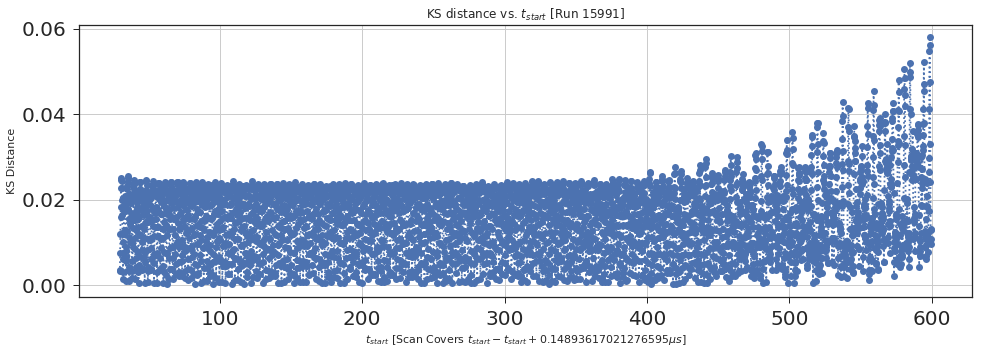

In [18]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.show()

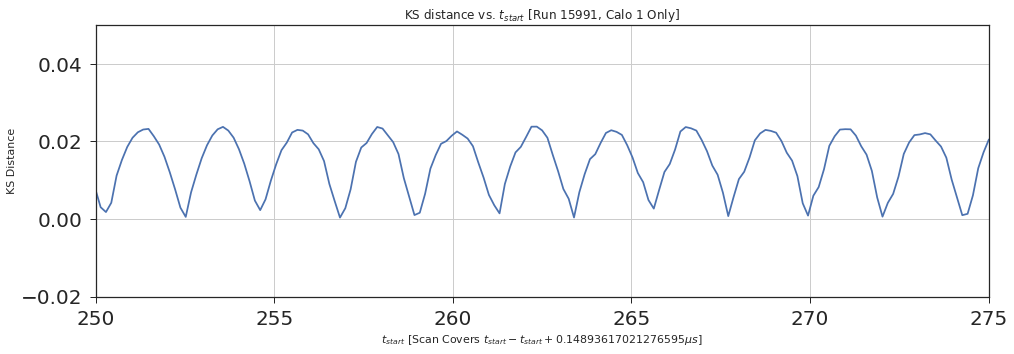

In [19]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,'-')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991, Calo 1 Only]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.xlim(250,275)
plt.ylim(-0.02,0.05)
plt.grid()
plt.show()

In [20]:
hspec = evt_time.Clone()
hspec.SetTitle("KS Distance vs. Time; Time [#mus]; d_{KS}")
hspec.Reset()
#hspec = r.TH1D("hspec","hspec",4700,0,700)
for i, ksi in enumerate(zip(times,ks)):
    binnum = hspec.FindBin(ksi[0])
    hspec.SetBinContent(binnum,ksi[1])

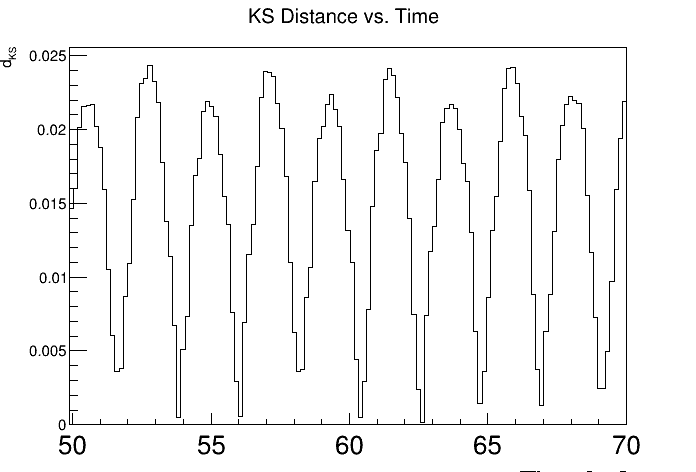

In [21]:
c = r.TCanvas()
hspec.Draw()
hspec.GetXaxis().SetRangeUser(50,70)
c.Draw()

In [22]:
hspec_orig = hspec.Clone() #keep this one unchanged so we can keep getting fit histograms from it

In [23]:
hspec2 = hspec.Clone()
hspec3 = hspec.Clone()
hspec4 = hspec.Clone()

In [24]:
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def peak_fit_sine(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3]

def peak_fit_sine_2(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3] +p[4]*r.TMath.Sin(omega*x[0] + p[2])

func1 = r.TF1("simplesine", peak_fit_sine, 50,350,4)
func1.SetParNames('A','R','#phi','+ C')
func1.SetParameters(0.03,0,0,0.002)
func1.SetParLimits(0,0.02,100)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("complexsine", peak_fit_sine_2, 50,350,5)
func2.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', '#phi_{2}')
func2.SetParameters(0.03,0,0,0.002,0.002,0)
func2.SetParLimits(0,0.02,100)
func2.SetLineColor(3)
func2.SetNpx(1000)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


 FCN=0.0201789 FROM MINOS     STATUS=SUCCESSFUL    366 CALLS        2536 TOTAL
                     EDM=1.49101e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            2.35385e-02   3.06825e-02  -3.71341e-05  -1.68684e-02
   2  R           -1.13611e+02   4.26641e+04  -6.62780e+00   1.97735e-06
   3  #phi         4.15192e+00   3.72653e+00  -8.81513e-05  -1.40829e-01
   4  + C         -4.53881e-04   7.91218e-03   7.91218e-03   1.09485e-01


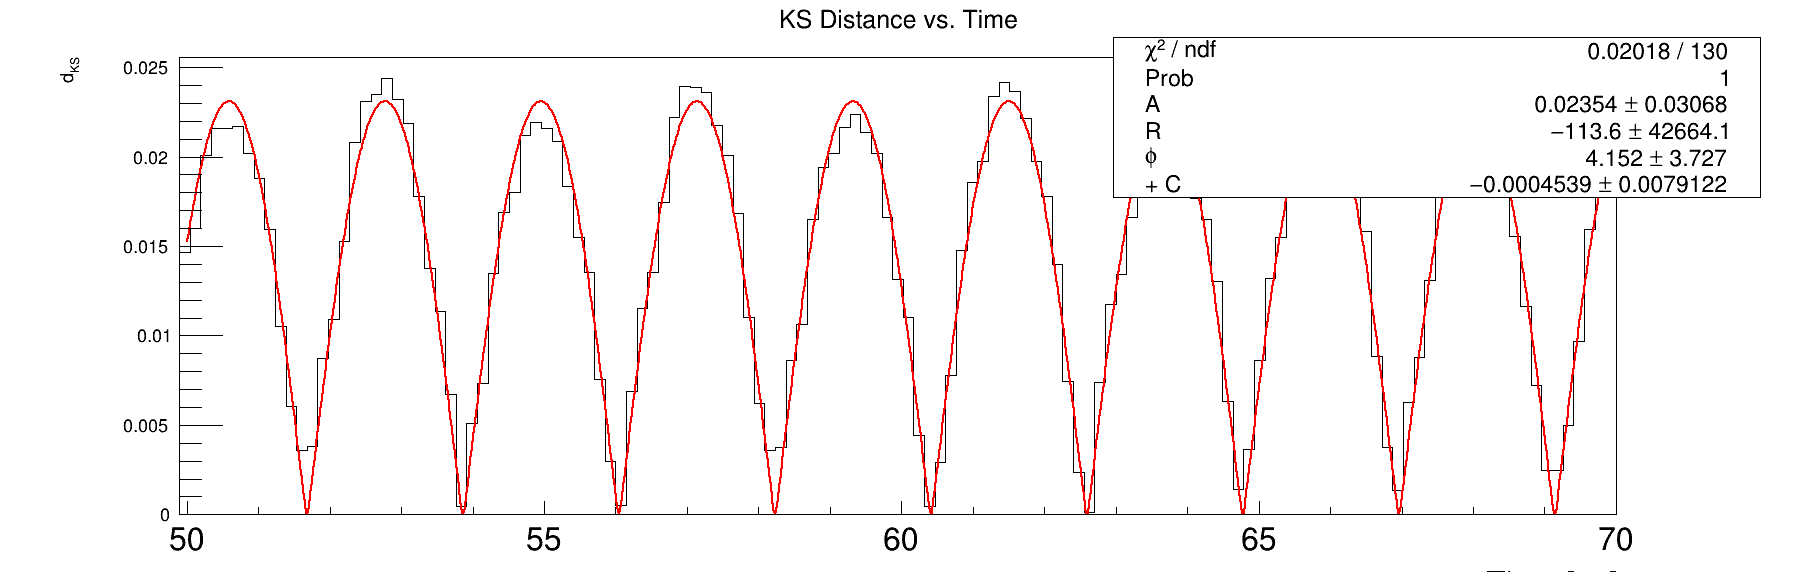

In [25]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()

hspec2.GetXaxis().SetRangeUser(50,550)
hspec.Fit("simplesine","REMB")
hspec2.GetXaxis().SetRangeUser(50,70)

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


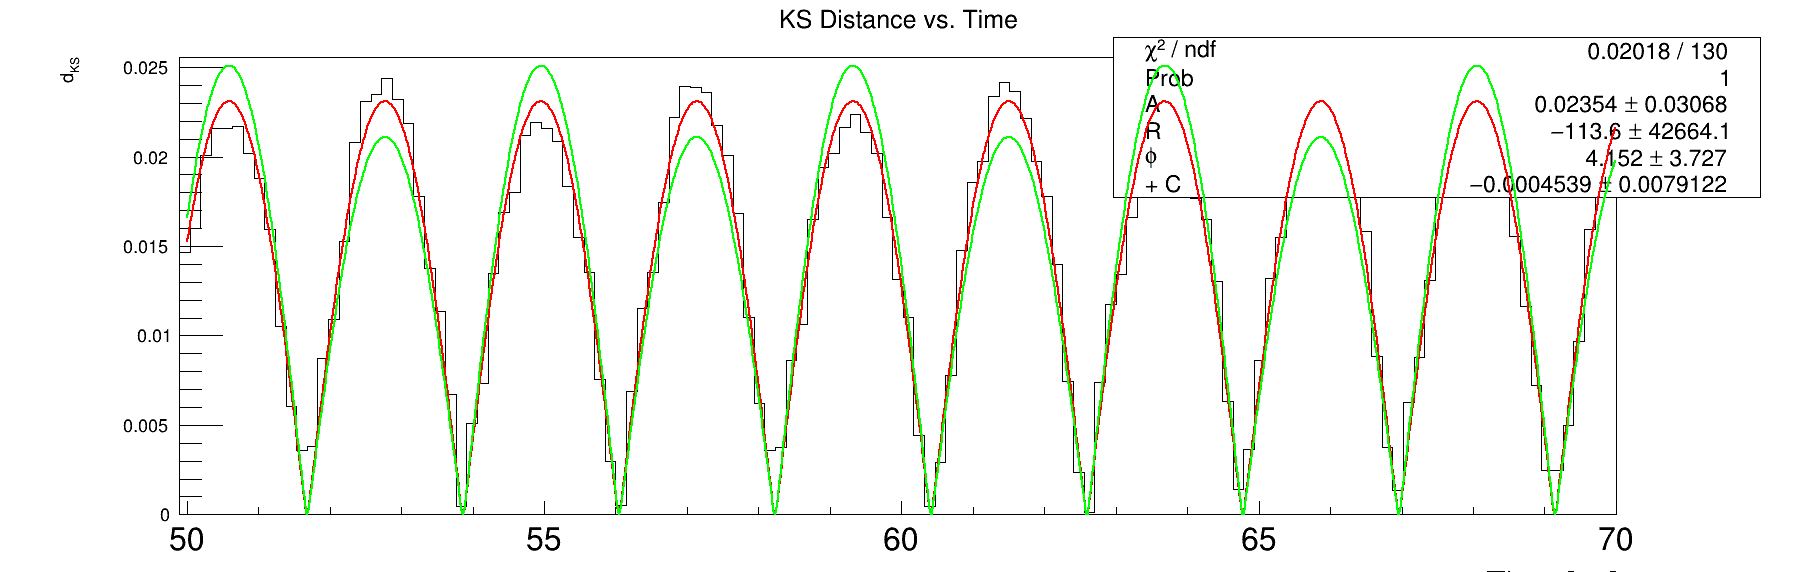

In [26]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()
for i in range(4):
    func2.SetParameter(i, func1.GetParameter(i))    
func1.Draw("SAME")
func2.Draw("SAME")
c.Draw()

func2.FixParameter(2, func1.GetParameter(2))

 FCN=0.0177551 FROM MINOS     STATUS=SUCCESSFUL     72 CALLS        3596 TOTAL
                     EDM=1.48135e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.36003e-02   3.02506e-02   8.29038e-05   5.70952e-03
   2  R           -1.14271e+02   4.21578e+04  -7.71479e+01  -3.87718e-08
   3  #phi_{1}     4.15188e+00   3.67765e+00   6.49094e-03  -4.27722e-04
   4  + C         -4.47141e-04   7.89984e-03  -1.21691e-05   5.09338e-02
   5  A_{2}       -7.96460e-04   1.63741e-02   1.63741e-02  -8.77763e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


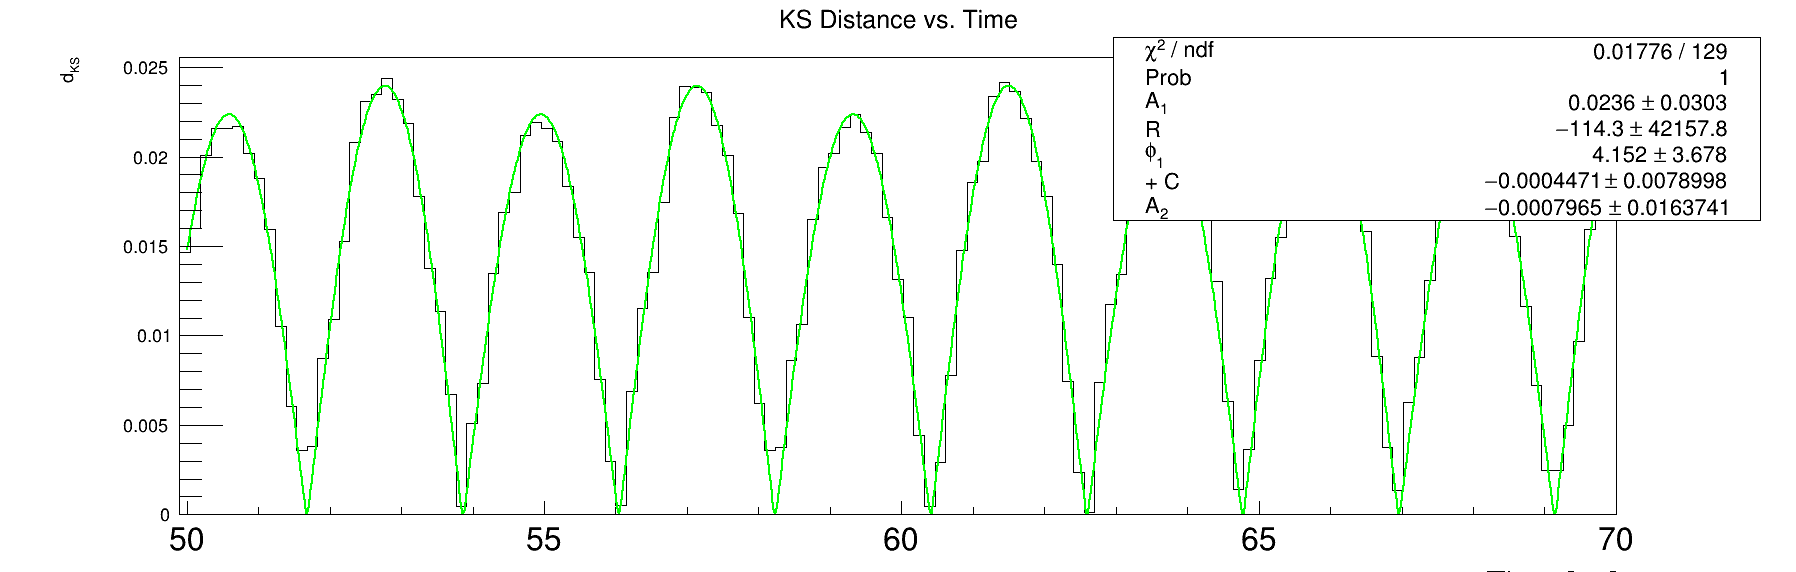

In [27]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.Fit("complexsine","REMB")
#func2.Draw("SAME")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


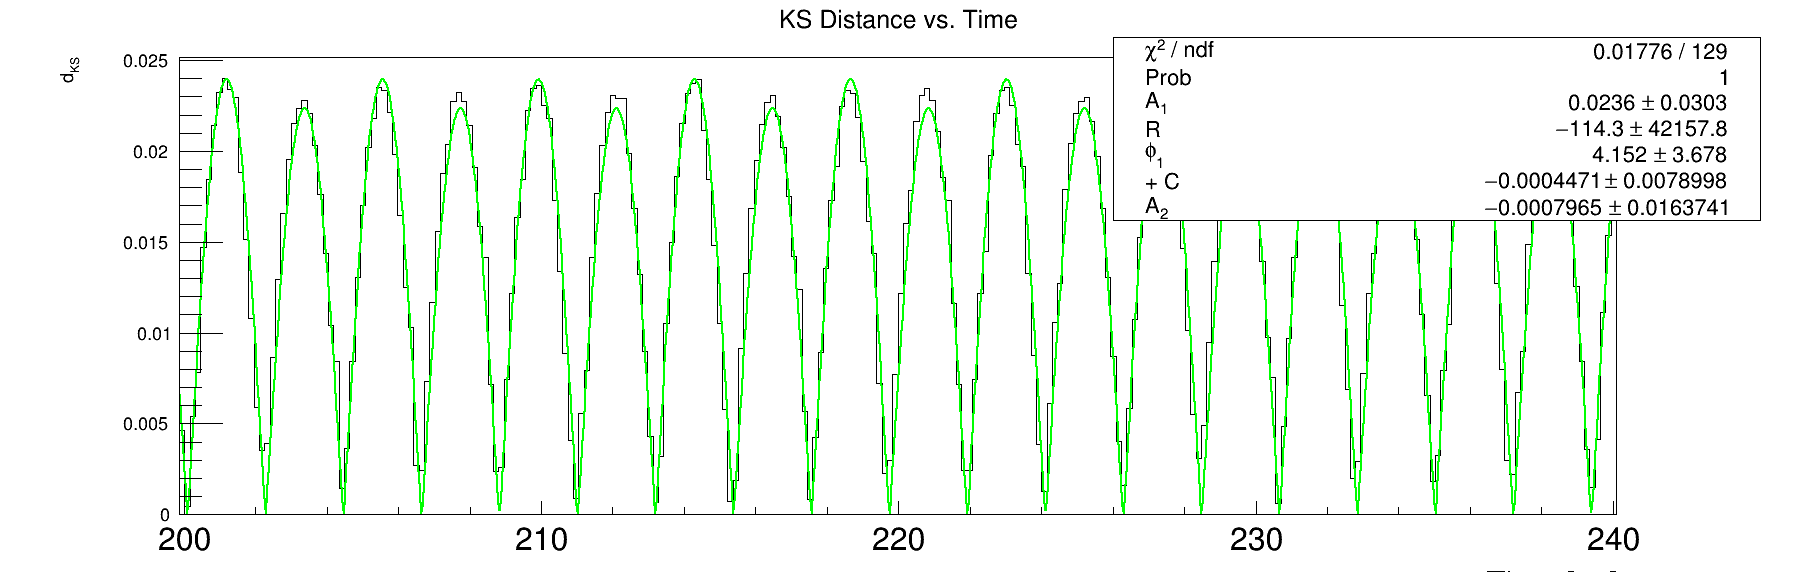

In [28]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(200,240)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


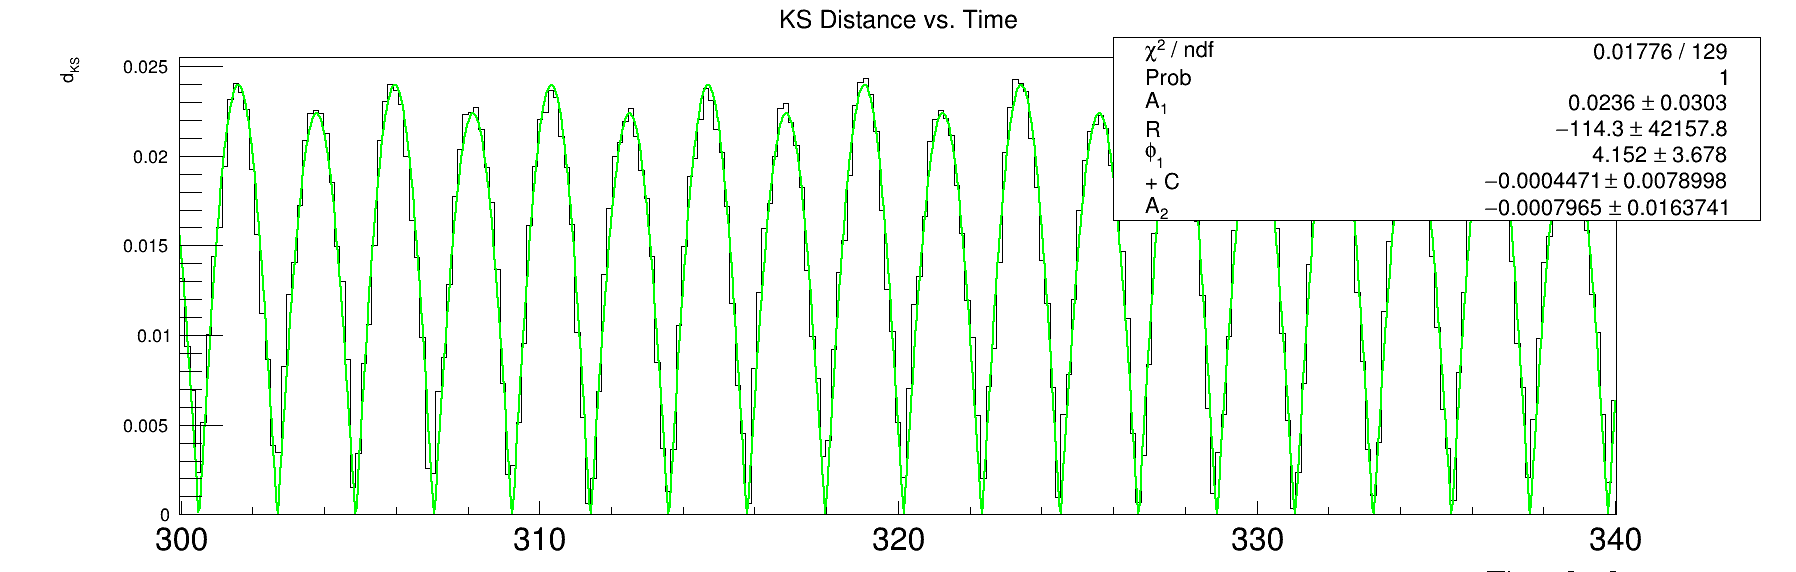

In [29]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(300,340)
c.Draw()

hi


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


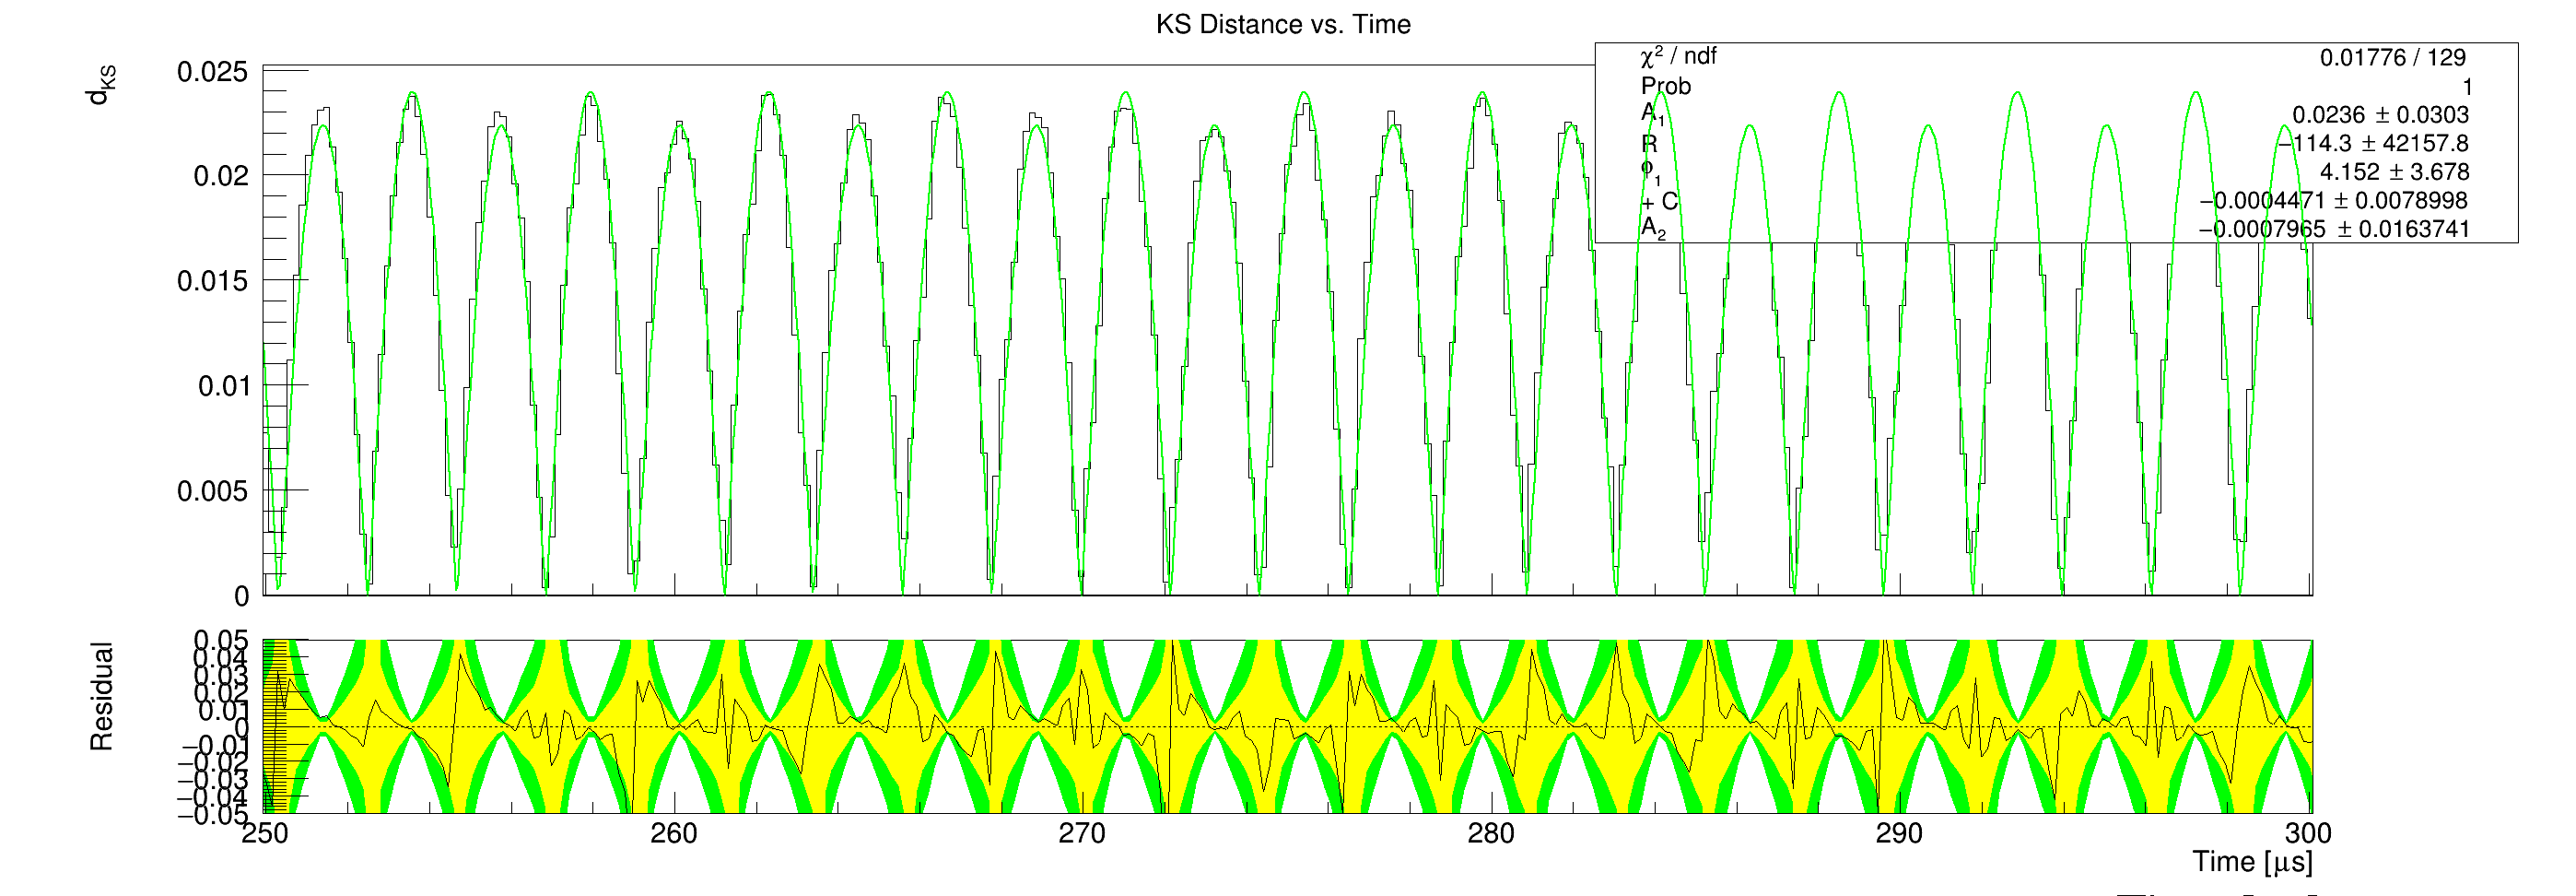

In [30]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(250,300)

c3.Draw()

try:
    rp1.Delete()
except:
    print("hi")

rp1 = r.TRatioPlot(hspec2)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

div = 3
for i in range(50,600,div):
    hspec2.GetXaxis().SetRangeUser(i,i+20)
    c3.Update()
    c3.Print("./images/rp1_"+str(i).zfill(4)+".png")
c3.Draw()

---

### Lets add in the triangle wave to the fit function

In [32]:
from scipy import signal

/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jlab/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


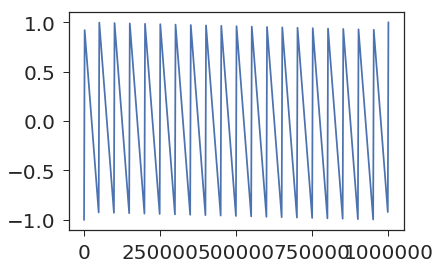

In [33]:
t = np.linspace(0, 1000000, 500)
plt.plot(t, signal.sawtooth(2 * np.pi * 5 * -1*t))

In [52]:
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def peak_fit_sine_3(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3] +p[4]*r.TMath.Sin(omega*x[0] + p[2]) + p[5]*signal.sawtooth(-2*omega*x[0] + p[2])

func3 = r.TF1("trisine", peak_fit_sine_3, 50,350,6)
func3.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', 'A_{3}')
func3.SetParameters(0.03,0,0,0.002,0.002,4*0.000842)
func3.SetParLimits(0,0.02,100)
func3.SetLineColor(4)
func3.SetNpx(10000)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


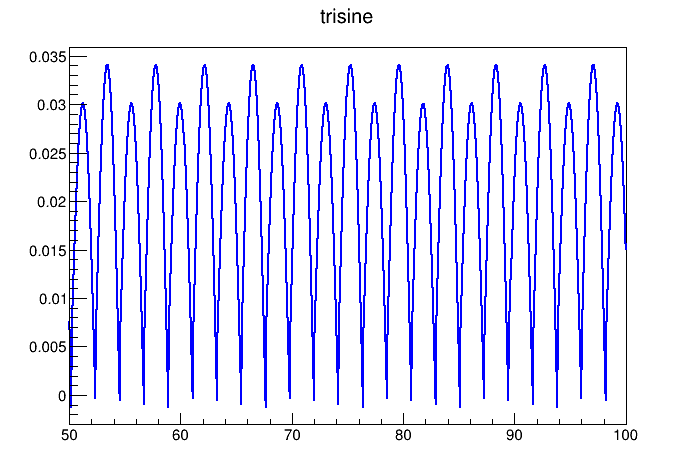

In [53]:
c = r.TCanvas()
func3.Draw()
func3.GetXaxis().SetRangeUser(50,100)
c.Draw()

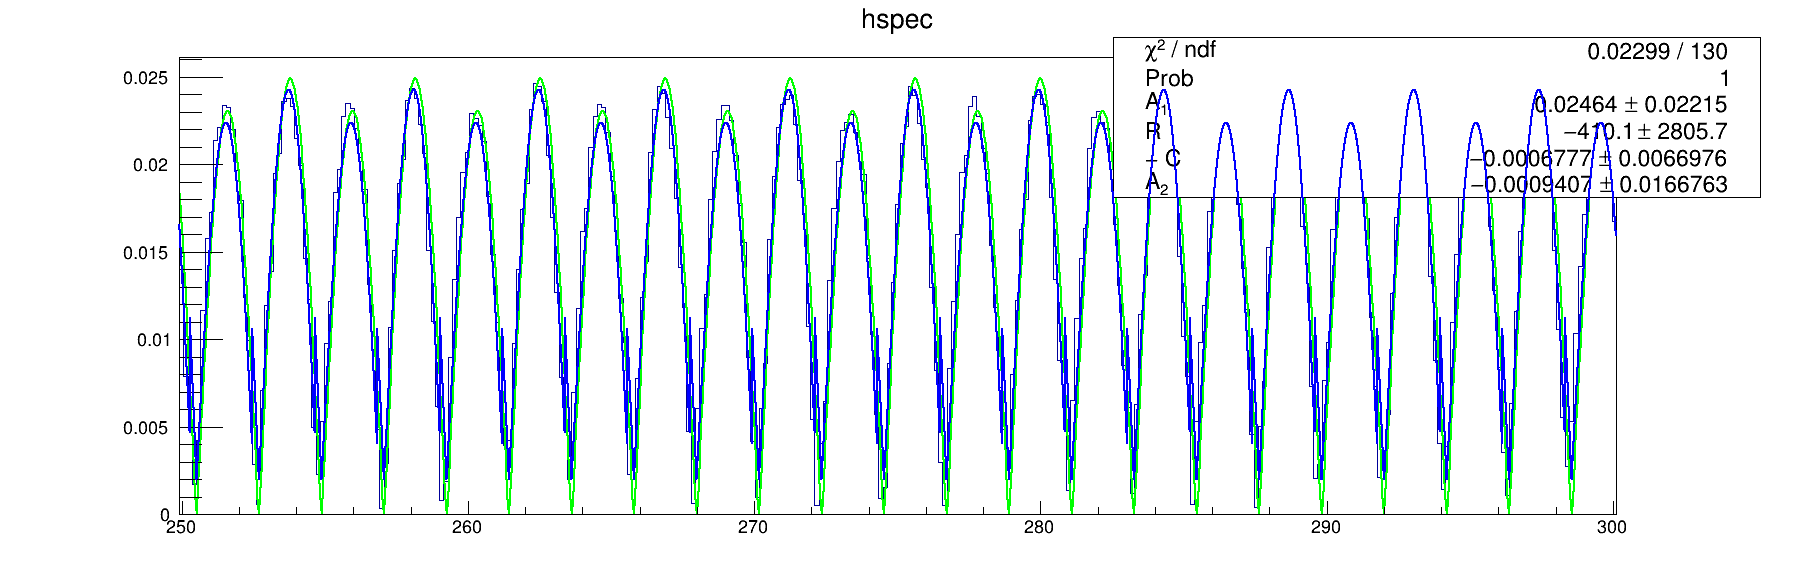

In [54]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
for i in range(5):
    func3.SetParameter(i, func2.GetParameter(i))    
#func2.Draw("SAME")
func3.Draw("SAME")
c.Draw()

In [ ]:
c = r.TCanvas("c","c",1800,600)
hspec3.Draw()
hspec3.Fit("trisine","REMB")
c.Draw()

In [ ]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec3.Draw()
hspec3.GetXaxis().SetRangeUser(250,300)

c3.Draw()

try:
    rp3.Delete()
except:
    print("hi")

rp3 = r.TRatioPlot(hspec3)
rp3.Draw()
rp3.GetLowerRefYaxis().SetTitle("Residual")
rp3.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

In [ ]:
hspec_resid3 = hspec3.Clone()
hspec_resid3.Reset()

residVec = []
nBins = hspec3.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec3.GetXaxis().GetBinCenter(i)
    if (binCenterX > 30 and binCenterX < 600):
        residVec.append( (binCenterX, hspec3.GetBinContent(i) - func3.Eval(binCenterX) ) )
        hspec_resid3.SetBinContent(i, hspec3.GetBinContent(i) - func3.Eval(binCenterX))
    else:
        hspec_resid3.SetBinContent(i, 0)

In [ ]:
c = r.TCanvas("c","c",1800,600)
hspec_resid3.GetXaxis().SetRangeUser(150,300)
hspec_resid3.GetYaxis().SetRangeUser(-0.01,0.01)
hspec_resid3.Draw()
c.Draw()

---

In [41]:
func3.GetParameter(5)

0.00045352495621760224

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


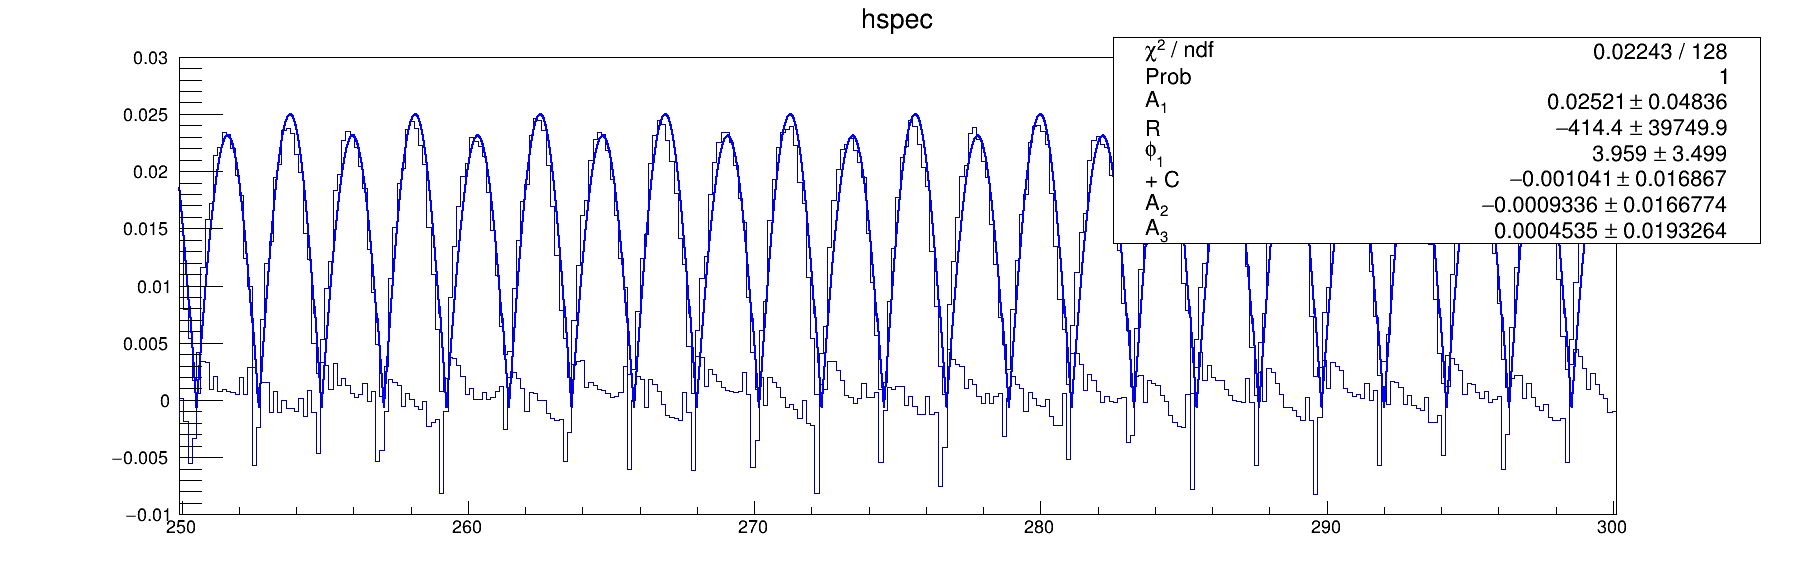

In [51]:
hspec_resid3 = hspec3.Clone()
hspec_resid3.Reset()

func3.SetParameter(5,4*0.000842)

residVec = []
nBins = hspec3.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec3.GetXaxis().GetBinCenter(i)
    if (binCenterX > 30 and binCenterX < 600):
        residVec.append( (binCenterX, hspec3.GetBinContent(i) - func3.Eval(binCenterX) ) )
        hspec_resid3.SetBinContent(i, hspec3.GetBinContent(i) - func3.Eval(binCenterX))
    else:
        hspec_resid3.SetBinContent(i, 0)
        
c = r.TCanvas("c","c",1800,600)
hspec3.Draw()
hspec_resid3.GetXaxis().SetRangeUser(150,300)
hspec3.GetYaxis().SetRangeUser(-0.01,0.03)
hspec_resid3.Draw("SAME")
c.Draw()